# Demo - Generate Orientation Labels from Road Vectors

## Process
1. Get satellite image and road mask. 
2. Skeletonize the road mask to single pixel width, if necessary.
3. Use SKNW library to generate road graph. 
4. Convert each point pair in road graph to unit directonal vector (ref equation 1). 
5. Convert vectors to polar domain (ref equation 2). 
6. Following equation 3, create new image and fill the orientation vector. 

In [11]:
import numpy as np
from numpy import ma
import os
import matplotlib

import cv2
import matplotlib.pyplot as plt

from skimage.morphology import skeletonize
from data_utils import affinity_utils

%matplotlib inline

### Read Image and Gaussian Mask

In [12]:
satellite_image = cv2.imread("../assests/images/AOI_2_Vegas_img33.png")
gaussian_road_mask = cv2.imread("../assests/images/mask_AOI_2_Vegas_img33.png",0)

In [13]:
gaussian_road_mask = gaussian_road_mask.astype(np.float)

### Binarize the Road Mask

In [14]:
# Threshold to binarize the gaussian road mask
threshold = 0.76

road_mask = np.copy(gaussian_road_mask/255.0)
road_mask[road_mask > threshold] = 1
road_mask[road_mask <= threshold] = 0

### Visualize satellite image and road mask

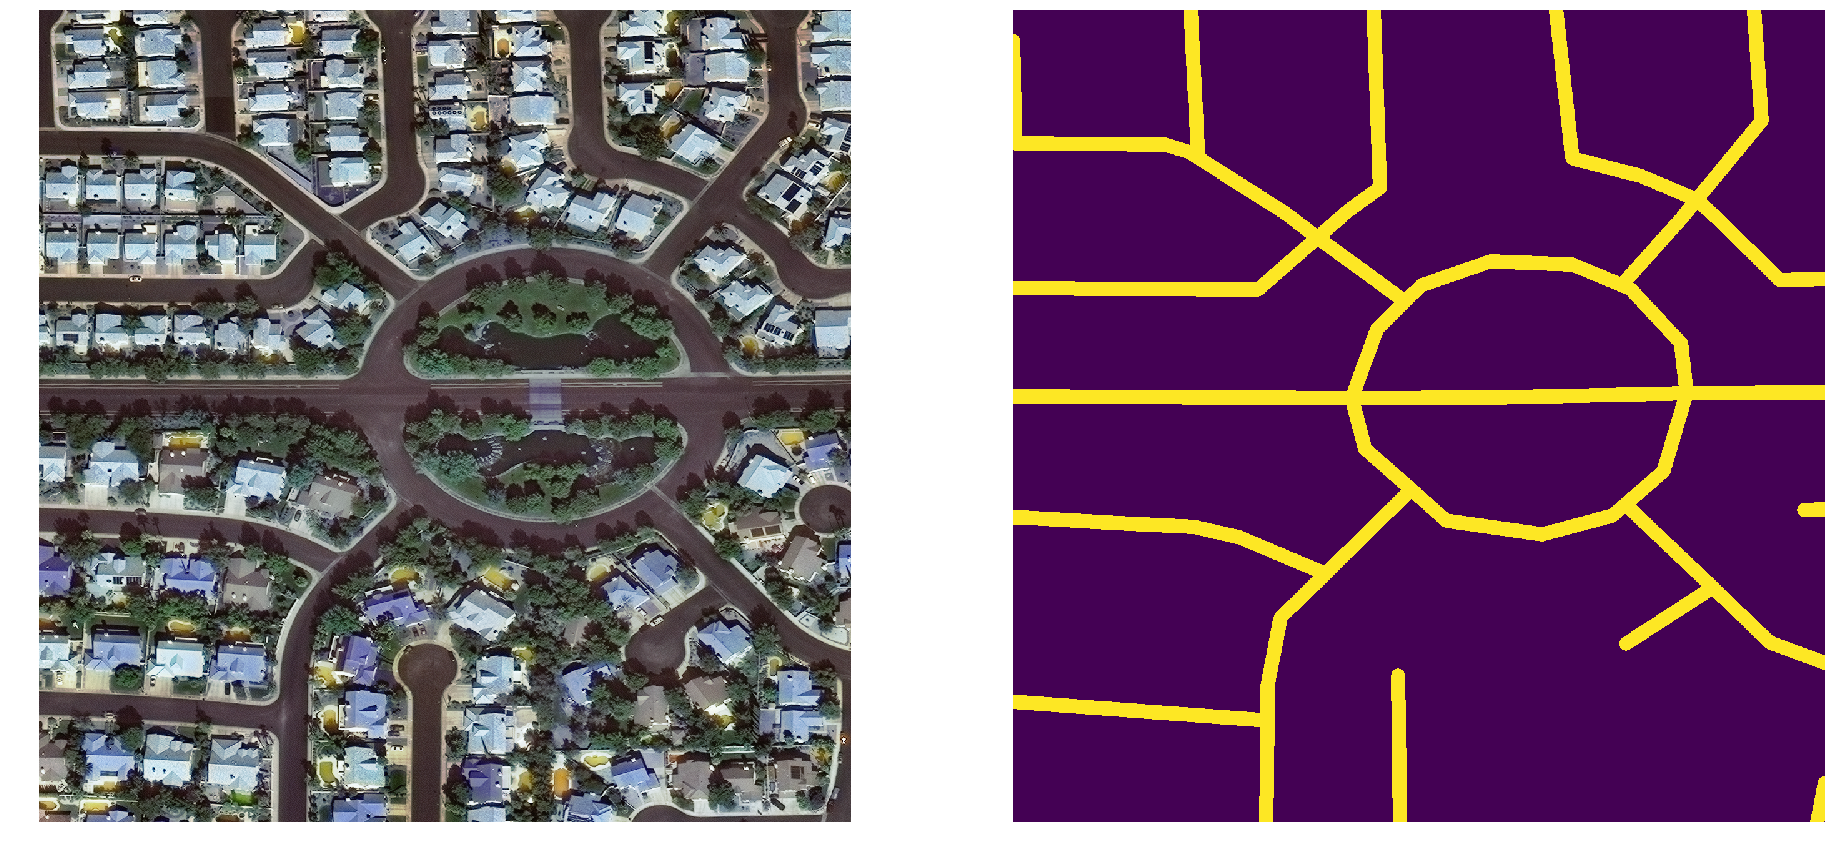

In [15]:
plt.figure(figsize=(32,32))
plt.subplot(121)
plt.axis('off')
plt.imshow(satellite_image)
plt.subplot(122)
plt.axis('off')
plt.imshow(road_mask.astype(np.uint8))

### Overlay Graph with intersection points on satellite image

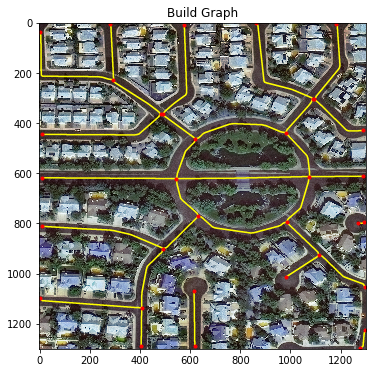

In [16]:
from skimage.morphology import skeletonize
from skimage import data
from data_utils import sknw

# skeletonize the binary road mask
skeleton = skeletonize(road_mask).astype(np.uint16)

# build graph from skeleton
graph = sknw.build_sknw(skeleton)

# draw image
plt.figure(figsize=(6,6))
plt.imshow(satellite_image)

# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'yellow')
    
# draw node by o
node, nodes = graph.node, graph.nodes()
ps = np.array([node[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')

# title and show
plt.title('Build Graph')
plt.show()

### Generate Orienation ground truth

In [17]:
# Smooth the road graph with tolerance=4 and get keypoints of road segments
keypoints = affinity_utils.getKeypoints(gaussian_road_mask, smooth_dist=4)
h,w = road_mask.shape

# generate orienation mask in euclidean and polar domain
vecmap_euclidean,orienation_angles = affinity_utils.getVectorMapsAngles((h,w),keypoints,theta=10,bin_size=10)

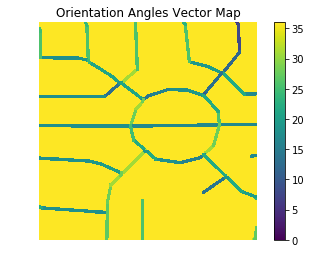

In [18]:
plt.axis('off')
plt.title("Orientation Angles Vector Map")
plt.imshow(orienation_angles, vmin=0, vmax=36)
plt.colorbar()
plt.show()

In [19]:
def plotVecMap(vectorMap,image,figsize_=(6,6), name=''):
    fig = plt.figure(figsize=figsize_)
    plt.axis('off')
    plt.imshow(image)

    U = vectorMap[:,:,0] * -1
    V = vectorMap[:,:,1]
    X, Y = np.meshgrid(np.arange(U.shape[0]), np.arange(U.shape[1]))
    M = np.zeros(U.shape, dtype='bool')
    M[U**2 + V**2 < 0.5 * 0.5] = True
    U = ma.masked_array(U, mask=M)
    V = ma.masked_array(V, mask=M)

    s = 15
    Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s],scale=70,headaxislength=3,headwidth=4,
                   width=0.008,alpha=.8, color='y')
    fig = matplotlib.pyplot.gcf()

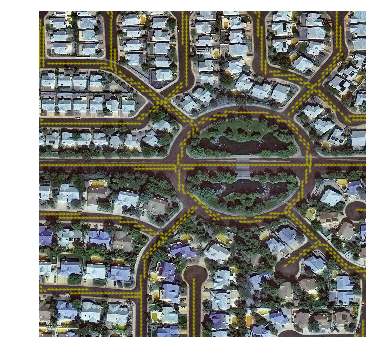

In [20]:
plotVecMap(vecmap_euclidean, satellite_image)